In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['axes.grid'] = False
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (ModelCheckpoint, LearningRateScheduler, Callback)
from tensorflow.keras.metrics import AUC

In [2]:
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
tqdm.pandas()
from tokenizers import Tokenizer, models

In [3]:
DATA_FOLDER = "../../data"
DATA_TRANSLATED = "../../data"

In [4]:
import sys
sys.path.append("../utils/")
from helpers import regular_encode, roc_auc, fast_encode, build_lrfn

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

In [7]:
train1 = pd.read_csv(DATA_FOLDER + "/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv(DATA_FOLDER + "/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv(DATA_FOLDER + '/validation.csv')
test = pd.read_csv(DATA_FOLDER + '/test.csv')

In [8]:
# Combine train1 with a subset of train2
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000, random_state=42)
])

In [9]:
AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 2
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 224
MODEL = 'jplu/tf-xlm-roberta-large'

In [10]:
tokenizer =AutoTokenizer.from_pretrained(MODEL)

In [11]:
%%time
x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_test  = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

CPU times: user 2min 47s, sys: 548 ms, total: 2min 47s
Wall time: 2min 47s


In [12]:
BATCH_SIZE = 64
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
#     .shuffle(2048)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [13]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [14]:
def build_model(transformer, loss='binary_crossentropy', max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(64, activation='relu')(cls_token)
    out = Dropout(0.35)(out)
    out = Dense(1, activation='sigmoid')(out)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss=loss, metrics=[AUC()])
    return model

In [15]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=MAX_LEN)

CPU times: user 5.62 s, sys: 1.76 s, total: 7.38 s
Wall time: 7.65 s


In [16]:
MODEL_PATH = '../models/savedmodels/model09333.h5'
model.load_weights(MODEL_PATH)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 224)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 224, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout_74 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 559,956,097
Trainable params: 559,956,097
Non-trainable params: 0
_______________________________________________

In [18]:
sub = pd.read_csv(DATA_FOLDER + '/sample_submission.csv')

In [19]:
valid_pred = model.predict(valid_dataset, verbose=1)

125/125 [==============================] - 186s 1s/step


In [20]:
# add a new column in the original data-model prediction
valid['pred'] = valid_pred

In [30]:
uncertain_toxic = pd.concat([
    valid[["comment_text", "toxic", "pred"]].query("toxic == 1 & pred < 0.65"),
    valid[["comment_text", "toxic", "pred"]].query("toxic == 1 & pred > 0.65").sample(frac=0.2, random_state=0)
])

In [31]:
uncertain_nontoxic = pd.concat([
    valid[["comment_text", "toxic", "pred"]].query("toxic == 0 & pred > 0.2 & pred < 0.65"),
    valid[["comment_text", "toxic", "pred"]].query("toxic == 0 & pred <= 0.2").sample(frac=0.2, random_state=0)
])

In [32]:
uncertain = pd.concat([uncertain_nontoxic, uncertain_toxic], axis=0)
uncertain.drop(columns=['pred'], inplace=True)
uncertain.to_csv(DATA_FOLDER + "/valid_uncertain.csv", index=False)

In [33]:
uncertain.shape

(3108, 2)

In [ ]:
n_steps = train.shape[0] // BATCH_SIZE
train_pred = model.predict(train_dataset, steps=n_steps, verbose=1)

3511/6808 [==============>...............] - ETA: 1:23:53

In [ ]:
len(train_pred)
# train.shape

In [ ]:
y_train_true = y_train[:len(train_pred)]

In [ ]:
train = train.iloc[:len(train_pred), :]
train['pred'] = train_pred

In [ ]:
uncertain_toxic = pd.concat([
    train[["comment_text", "toxic", "pred"]].query("toxic == 1 & pred < 0.65"),
    train[["comment_text", "toxic", "pred"]].query("toxic == 1 & pred > 0.65").sample(frac=0.2, random_state=0)
])

In [ ]:
uncertain_nontoxic = pd.concat([
    train[["comment_text", "toxic", "pred"]].query("toxic == 0 & pred > 0.2 & pred < 0.65"),
    train[["comment_text", "toxic", "pred"]].query("toxic == 0 & pred <= 0.2").sample(frac=0.2, random_state=0)
])

In [ ]:
uncertain = pd.concat([uncertain_nontoxic, uncertain_toxic], axis=0)
uncertain.drop(columns=['pred'], inplace=True)
uncertain.shape

In [ ]:
uncertain.to_csv(DATA_FOLDER + "/train_uncertain.csv", index=False)

In [ ]:
plt.hist(train_pred[y_train_true == 0], bins=100, label="non-toxic")
plt.hist(train_pred[y_train_true == 1], bins=100, alpha=0.5, label="toxic")
plt.xlabel("prdicted probability")
plt.ylabel("Number of counts")
plt.xlim(0.06,1)
plt.ylim(0,2000)
plt.legend();

In [ ]:
(train_pred[y_train_true == 0] > 0.2).sum()

In [ ]:
(train_pred[y_train_true == 1] > 0.65).sum()

In [ ]:
auc_score_train = roc_auc_score(y_train_true, train_pred)
auc_score = roc_auc_score(y_valid, valid_pred)

In [21]:
auc_score = roc_auc_score(y_valid, valid_pred)
# valid_pred

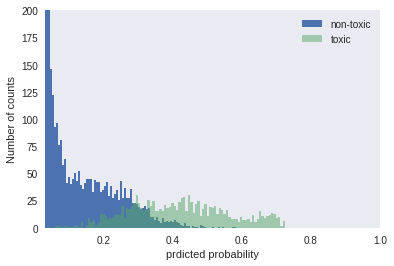

In [22]:
plt.hist(valid_pred[y_valid == 0], bins=100, label="non-toxic")
plt.hist(valid_pred[y_valid == 1], bins=100, alpha=0.5, label="toxic")
plt.xlabel("prdicted probability")
plt.ylabel("Number of counts")
plt.xlim(0.03,1)
plt.ylim(0,200)
plt.legend();

In [23]:
mask = (valid_pred[y_valid == 1] < 0.36)
mask.sum()

464

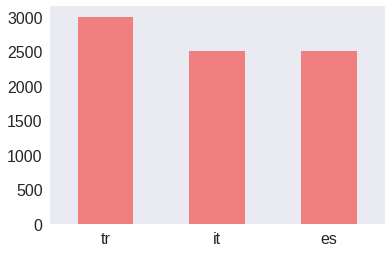

In [24]:
valid.lang.value_counts().plot.bar(rot=0, fontsize=16, color='lightcoral')

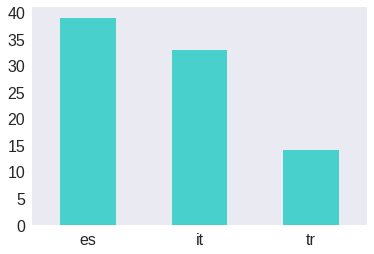

In [25]:
valid[["lang", "toxic", "pred"]].query("toxic == 0 & pred > 0.36").lang.value_counts().plot.bar(rot=0, fontsize=16, color='mediumturquoise')

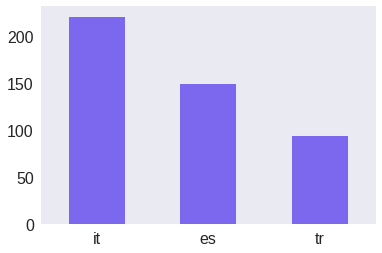

In [26]:
valid[["lang", "toxic", "pred"]].query("toxic == 1 & pred < 0.36").lang.value_counts().plot.bar(rot=0, fontsize=16, color='mediumslateblue')

In [27]:
(valid_pred[y_valid == 0] > 0.15).sum()

1117

In [28]:
print(max(valid_pred[y_valid == 1]))
max(valid_pred[y_valid == 0])

[0.7258038]


array([0.5822199], dtype=float32)

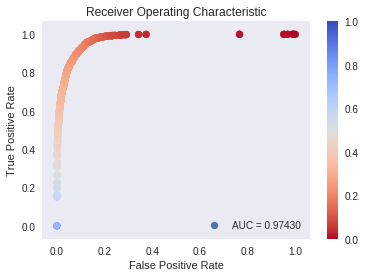

In [29]:
fpr, tpr, threshold = roc_curve(y_valid, valid_pred)
cm = plt.cm.get_cmap('coolwarm_r')
plt.title('Receiver Operating Characteristic')
sc = plt.scatter(fpr, tpr, c=threshold, cmap=cm, label = f'AUC = {auc_score:.5f}')
plt.colorbar(sc)
plt.legend(loc = 'lower right')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.clim(0,1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()